## Imports

In [1]:
import torch
from datasets.nsd import NaturalScenesDataset
from datasets.nsd_features import NSDFeaturesDataset
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from utils.img_utils import save_images
from sklearn.metrics import pairwise_distances
from sklearn import manifold
import pandas as pd
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from utils.nsd_utils import parse_rois, get_roi_indices
import io
import torch.nn.functional as F
from tqdm import tqdm
import cv2

/home/diego/miniconda3/envs/braindive/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Function to compute cosine similarities and decompose

In [3]:
def decompose_vector(directiona1_vector, attribute_vectors):

    cosines = []
    for attribute_vector in attribute_vectors:
        cosine = 1 - pairwise_distances(directiona1_vector.reshape(1, -1), attribute_vector.reshape(1, -1), metric='cosine')[:, 0]
        cosines.append(cosine)
    cosines = np.array(cosines)[:,0]

    weights = torch.nn.Parameter(torch.randn(len(attribute_vectors),1).to(device))
    optimizer = torch.optim.Adam([weights], lr=1e-3)

    n_epochs = 1000
    alpha = 0
    sims = []
    for _ in range(n_epochs):
        with torch.no_grad():
            weights /= weights.abs().sum()
        pred = weights.T @ attribute_vectors
        cosine_sim = F.cosine_similarity(pred, torch.from_numpy(directiona1_vector).to(device).unsqueeze(0), dim=1)
        loss = -cosine_sim + alpha * weights.abs().sum()
        sims.append(cosine_sim.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    weights = weights.detach().cpu().numpy().squeeze()

    return weights, cosines, cosine_sim.item()

In [4]:
subject = 1
roi = 'PPA'
hemisphere = 'right'

attribute_vectors = []
attribute_names = []
is_low = []
# load low-level attributes
for att in ['lightness', 'saturation', 'warmth', 'contrast', 'lightness_rev']:
    vec = np.load(f'./direction_vectors/{subject}_{att}.npy')
    attribute_vectors.append(vec)
    attribute_names.append(att)
    is_low.append(True)
# load high-level attributes
df = pd.read_csv('attributes.tsv', sep='\t')
for desc in df['description']:
    vec = np.load(f'./direction_vectors/{desc}.npy')
    attribute_vectors.append(vec)
    attribute_names.append(desc)
    is_low.append(False)
attribute_names = np.array(attribute_names)
is_low = np.array(is_low)
attribute_vectors = np.array(attribute_vectors)
attribute_vectors = torch.from_numpy(attribute_vectors).to(device).float()

# activation direction vectors
filenames = sorted([f for f in os.listdir(f'./direction_vectors') if f'{subject}_{roi}_{hemisphere}' in f])

cosines = {}
weights = {}
for f in filenames:
    directiona1_vector = np.load(f'./direction_vectors/{f}')
    weights_, cosines_, _ = decompose_vector(directiona1_vector, attribute_vectors)
    for i, name in enumerate(attribute_names):
        cosines[name] = cosines.get(name, []) + [cosines_[i]]
        weights[name] = weights.get(name, []) + [weights_[i]]


### Visualize distribution of attribute similarities

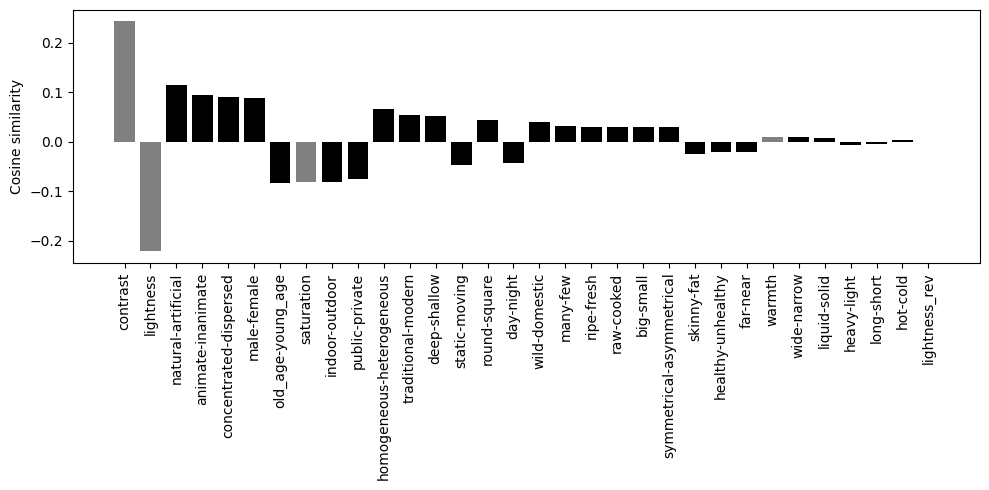

In [5]:
cosines_ = np.array([cosines[name] for name in attribute_names])[:,0]
order = np.argsort(np.abs(cosines_))[::-1]
# order = np.argsort(np.abs(cosines_.mean(-1)))[::-1]

# plt.figure(figsize=(10,5))
# plt.axhline(0, color='r', linestyle='--', alpha=0.5)
# for i, v in enumerate(cosines_[order]):
#     plt.boxplot(v, positions=[i], widths=0.6, patch_artist=True, boxprops=dict(facecolor='grey' if is_low[order][i] else 'black'), medianprops=dict(color='red'))
# plt.xticks(range(len(attribute_names)), attribute_names[order], rotation=90)
# plt.ylabel('Cosine similarity')
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(10,5))
colors = ['grey' if l else 'black' for l in is_low[order]]
# plt.bar(attribute_names[order], cosines_.mean(-1)[order], color=colors)
plt.bar(attribute_names[order], cosines_[order], color=colors)
plt.xticks(rotation=90)
plt.ylabel('Cosine similarity')
plt.tight_layout()
plt.show()